# Machine learning workflow project
## Reading data

In [62]:
import pandas as pd
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Applying data cleaning and feature engineering functions

In [63]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [64]:
def apply_all(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    return df
    
train = apply_all(train)
holdout = apply_all(holdout)

## Exploring data
Lets look at SibSP and Parch columns, which give info on number of siblings and spouse and parents/children of a passener.

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


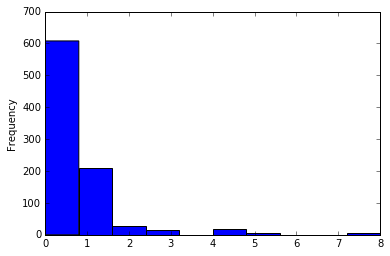

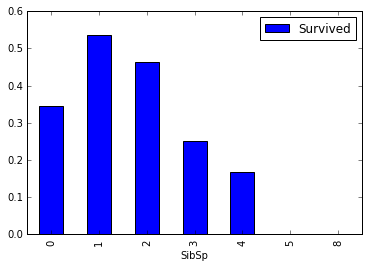

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
print(train['SibSp'].describe())
train['SibSp'].plot.hist()
sib_pivot = train.pivot_table(index='SibSp', values='Survived')
sib_pivot.plot.bar()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64


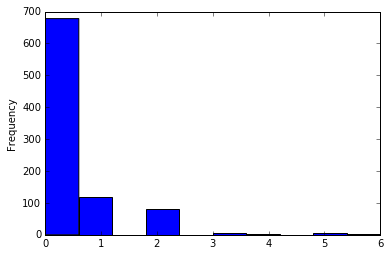

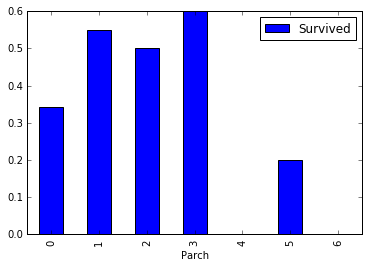

In [66]:
print(train['Parch'].describe())
train['Parch'].plot.hist()
parch_pivot = train.pivot_table(index='Parch', values='Survived')
parch_pivot.plot.bar()

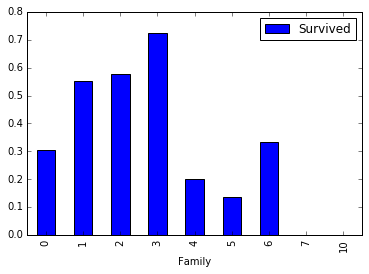

In [67]:
def add_family(df):
    df['Family'] = df['SibSp'] + df['Parch']
    return df

train = add_family(train)
holdout = add_family(holdout)

fam_pivot = train.pivot_table(index='Family', values='Survived')
fam_pivot.plot.bar()

Having 1 Sib/Spouse increases the chances of survival, but more decreases it.
Having multiple parents/children increases the chances of survival, except when having too many (5).
Having no family members at all gives a 0.3 chance of survival, while having more increases it up to a certain point.

Let's create a binary column to indicate if there is a family member.

In [68]:
def process_alone(df):
    df['isalone'] = df.apply(lambda x: int(x['Family']==0), axis=1)
    return df
train = process_alone(train)
holdout = process_alone(holdout)

## Feature selection

In [78]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def select_features(df):
    df = df.select_dtypes(include=[np.number])
    df = df[df.notnull()]
    all_y = df['Survived']
    all_X = df.drop(['Survived', 'PassengerId'], axis=1)
    model = RandomForestClassifier(random_state=1)
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)
    return all_X.columns[selector.support_]

features = select_features(train)
features

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'Family', 'isalone'],
      dtype='object')

## Hyperparameter Optimization

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    model_list = [{
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
    },
        {
    "name": "LogisticRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
        {
            "solver": ["newton-cg", "lbfgs", "liblinear"],
        }
    },
                {
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(),
    "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    }
    ]
    for model in model_list:
        print(model['name'])
        grid = GridSearchCV(model['estimator'], param_grid = model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model['best_score'] = grid.best_score_
        model['best_params'] = grid.best_params_
        model['best_estimator'] = grid.best_estimator_
    return model_list

result = select_model(train, features)

KNeighborsClassifier
LogisticRegression
RandomForestClassifier


In [80]:
result

[{'best_estimator': KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=1,
             weights='uniform'),
  'best_params': {'algorithm': 'kd_tree',
   'n_neighbors': 3,
   'p': 1,
   'weights': 'uniform'},
  'best_score': 0.7800224466891134,
  'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'),
  'hyperparameters': {'algorithm': ['ball_tree', 'kd_tree', 'brute'],
   'n_neighbors': range(1, 20, 2),
   'p': [1, 2],
   'weights': ['distance', 'uniform']},
  'name': 'KNeighborsClassifier'},
 {'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
            verbose=0, warm_start=False),


## Creating submission file for Kaggle

In [87]:
def save_submission_file(model, features, filename='submission.csv'):
    predictions = model.predict(holdout[features])
    submission = pd.DataFrame({'PassengerId' : holdout['PassengerId'], 'Survived' : predictions})
    submission.to_csv(filename)

save_submission_file(result[2]['best_estimator'], features)